# Predictive Analysis - Current Stint Penalty Minutes to Previous Stint Comparison

Age, percent through career, teammates of same nationality, and teammates of same nationality vs previous stint will be used to predict whether the current stint will have more or fewer penalty minutes per game compared to the previous stint.


## Load Data

In [1]:
import pandas as pd

df = pd.read_csv('Data/Gold/main.csv')

## Feature Design - Penalty Minutes vs Previous Stint

Exploratory Data Analysis revealed that there was a slight indication of a linear correlation between the number of teammates of the same nationality a player has and the number of penalty minutes per game they will be assessed. We seek to predict whether an increase or decrease in their penalty minutes per game will occur in a given stint, using the aforementioned input features.

In [2]:
# Sorting the dataframe by playerID and stint_index
df = df.sort_values(by=['playerID', 'stint_index'])

# Initialize the comparison column with null values
df['PIM_vs_prev_stint'] = None

# Iterate over each row and compare the current PIM_score with the previous PIM_score
for i in range(0, len(df)):
    current_row = df.iloc[i]
    if current_row['stint_index'] != 0:
        prev_row = df[(df['playerID'] == current_row['playerID']) & (df['stint_index'] == current_row['stint_index'] - 1)]
        if not prev_row.empty:
            prev_PIM_score = prev_row['PIM_per_game_score'].values[0]
            if current_row['PIM_per_game_score'] > prev_PIM_score:
                df.at[i, 'PIM_vs_prev_stint'] = 1
            else:
                df.at[i, 'PIM_vs_prev_stint'] = 0

# Display the updated dataframe
print(df.head())

# Write the updated dataframe to the CSV file
df.to_csv('Data/Gold/main.csv', index=False)


    playerID  year  stint tmID pos    GP    G     A   Pts   PIM  ...  \
0  abdelju01  2009      1  DET   L  50.0  3.0   3.0   6.0  35.0  ...   
1  abdelju01  2010      1  DET   L  74.0  7.0  12.0  19.0  61.0  ...   
2  abdelju01  2011      1  DET   L  81.0  8.0  14.0  22.0  62.0  ...   
3   abelcl01  1926      1  NYR   D  44.0  8.0   4.0  12.0  78.0  ...   
4   abelcl01  1927      1  NYR   D  23.0  0.0   1.0   1.0  28.0  ...   

   SOG_per_game_score  award_count_per_game_score  +/-_score  stint_score  \
0           -0.248378                         0.0  -1.282503    -1.315045   
1            1.329897                         0.0   1.157381     1.108070   
2           -1.081518                         0.0   0.125122     0.206975   
3            0.000000                         0.0   0.000000     2.257283   
4            0.000000                         0.0   0.000000    -0.554457   

   stint_vs_prev_stint  teammates_same_nationality  tsm_vs_prev_stint  \
0                  NaN         

<Axes: >

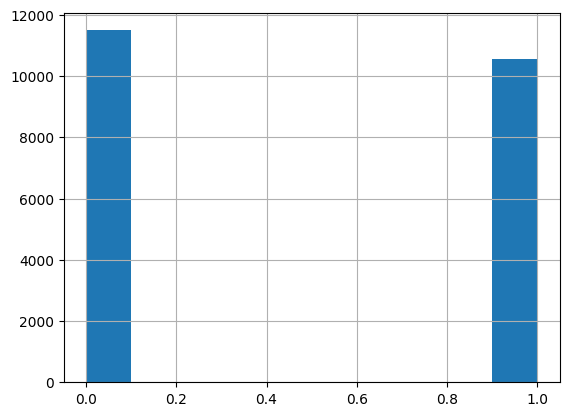

In [3]:
df['PIM_vs_prev_stint'].hist()

### Load Updated Data & Select Features for Analysis

The udpated table with the created feature is loaded, and null rows for that feature are dropped.  Data frame is then reduced to only input features and target column.


In [4]:
df = pd.read_csv('Data/Gold/main.csv')

df = df.dropna(subset=['PIM_vs_prev_stint'])

df = df[['year','age', 'percent_through_career', 'teammates_same_nationality', 'tsm_vs_prev_stint', 'PIM_vs_prev_stint']]

### Prepare Results Table


In [5]:
table_columns = ('Run', 'Mean CV ROC AUC', 'Mean CV F1', 'Test ROC AUC', 'Test F1', 'Train ROC AUC', 'Train F1'
)

results_table = []

results_table.append(table_columns)

## Random Forest Analysis

### Initial Run

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, roc_auc_score

# Split input features and target feature
X = df.drop(columns=['PIM_vs_prev_stint'])
y = df['PIM_vs_prev_stint']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model for classification
model = RandomForestClassifier(random_state=42)

# Define the scoring metrics
f1_scorer = make_scorer(f1_score, average='binary')
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Perform cross-validation and compute F1 and ROC AUC scores
cv_f1_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=f1_scorer)
cv_roc_auc_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=roc_auc_scorer)

# Train the model on the full training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Evaluate the model on the test set
test_f1 = f1_score(y_test, y_test_pred, average='binary')
test_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Make predictions on the training set
y_train_pred = model.predict(X_train)

# Evaluate the model on the training set
train_f1 = f1_score(y_train, y_train_pred, average='binary')
train_roc_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

# Feature importances
feature_importances = model.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the results
print("Cross-Validation F1 Scores:", cv_f1_scores)
print("Mean Cross-Validation F1:", cv_f1_scores.mean())
print("Cross-Validation ROC AUC Scores:", cv_roc_auc_scores)
print("Mean Cross-Validation ROC AUC:", cv_roc_auc_scores.mean())

print("Test Set F1 Score:", test_f1)
print("Test Set ROC AUC:", test_roc_auc)
print("Train Set F1 Score:", train_f1)
print("Train Set ROC AUC:", train_roc_auc)
print("Feature Importances:\n", feature_importances_df)

# Append results to the results table
results_table.append(('Initial Run', cv_roc_auc_scores.mean(), cv_f1_scores.mean(), test_roc_auc, test_f1, train_roc_auc, train_f1))



c:\Users\timgo\OneDrive\Desktop\School\Summer2024\Capstone\nwmsu_ms_capstone\.venv\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Cross-Validation F1 Scores: [0.47404628 0.4766969  0.48864668 0.48177888 0.49953747]
Mean Cross-Validation F1: 0.4841412416524749
Cross-Validation ROC AUC Scores: [0.52980115 0.53547805 0.5314933  0.52804671 0.54886555]
Mean Cross-Validation ROC AUC: 0.5347369532123498
Test Set F1 Score: 0.48255234297108673
Test Set ROC AUC: 0.5409748061664059
Train Set F1 Score: 1.0
Train Set ROC AUC: 1.0
Feature Importances:
                       Feature  Importance
2      percent_through_career    0.426820
0                        year    0.233717
3  teammates_same_nationality    0.159283
1                         age    0.134388
4           tsm_vs_prev_stint    0.045791


### Control - Only Age & Percent Through Career

In order to see if the teammate features we have developed improve model performance, we create a control model that excludes these features.

In [7]:
df = pd.read_csv('Data/Gold/main.csv')
df = df[['year','age', 'percent_through_career', 'PIM_vs_prev_stint']]
# Remove rows where 'PIM_vs_prev_stint' is NaN
df = df.dropna(subset=['PIM_vs_prev_stint'])

In [8]:
# Split input features and target feature
X = df.drop(columns=['PIM_vs_prev_stint'])
y = df['PIM_vs_prev_stint']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model for classification
model = RandomForestClassifier(random_state=42)

# Define the scoring metrics
f1_scorer = make_scorer(f1_score, average='binary')
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Perform cross-validation and compute F1 and ROC AUC scores
cv_f1_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=f1_scorer)
cv_roc_auc_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=roc_auc_scorer)

# Train the model on the full training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Evaluate the model on the test set
test_f1 = f1_score(y_test, y_test_pred, average='binary')
test_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Make predictions on the training set
y_train_pred = model.predict(X_train)

# Evaluate the model on the training set
train_f1 = f1_score(y_train, y_train_pred, average='binary')
train_roc_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

# Feature importances
feature_importances = model.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the results
print("Cross-Validation F1 Scores:", cv_f1_scores)
print("Mean Cross-Validation F1:", cv_f1_scores.mean())
print("Cross-Validation ROC AUC Scores:", cv_roc_auc_scores)
print("Mean Cross-Validation ROC AUC:", cv_roc_auc_scores.mean())

print("Test Set F1 Score:", test_f1)
print("Test Set ROC AUC:", test_roc_auc)
print("Train Set F1 Score:", train_f1)
print("Train Set ROC AUC:", train_roc_auc)
print("Feature Importances:\n", feature_importances_df)

# Append results to the results table
results_table.append(('Control', cv_roc_auc_scores.mean(), cv_f1_scores.mean(), test_roc_auc, test_f1, train_roc_auc, train_f1))


c:\Users\timgo\OneDrive\Desktop\School\Summer2024\Capstone\nwmsu_ms_capstone\.venv\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


### Reduced Features

Percent through career, year, and teammates_same_nationality were the top three features in the initial run with all features.  We will see if performance improves when these are the only features.

In [ ]:
df = pd.read_csv('Data/Gold/main.csv')
df = df[['year','teammates_same_nationality', 'percent_through_career', 'PIM_vs_prev_stint']]
# Remove rows where 'PIM_vs_prev_stint' is NaN
df = df.dropna(subset=['PIM_vs_prev_stint'])

In [ ]:

# Split input features and target feature
X = df.drop(columns=['PIM_vs_prev_stint'])
y = df['PIM_vs_prev_stint']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model for classification
model = RandomForestClassifier(random_state=42)

# Define the scoring metrics
f1_scorer = make_scorer(f1_score, average='binary')
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Perform cross-validation and compute F1 and ROC AUC scores
cv_f1_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=f1_scorer)
cv_roc_auc_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=roc_auc_scorer)

# Train the model on the full training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Evaluate the model on the test set
test_f1 = f1_score(y_test, y_test_pred, average='binary')
test_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Make predictions on the training set
y_train_pred = model.predict(X_train)

# Evaluate the model on the training set
train_f1 = f1_score(y_train, y_train_pred, average='binary')
train_roc_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

# Feature importances
feature_importances = model.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the results
print("Cross-Validation F1 Scores:", cv_f1_scores)
print("Mean Cross-Validation F1:", cv_f1_scores.mean())
print("Cross-Validation ROC AUC Scores:", cv_roc_auc_scores)
print("Mean Cross-Validation ROC AUC:", cv_roc_auc_scores.mean())

print("Test Set F1 Score:", test_f1)
print("Test Set ROC AUC:", test_roc_auc)
print("Train Set F1 Score:", train_f1)
print("Train Set ROC AUC:", train_roc_auc)
print("Feature Importances:\n", feature_importances_df)

# Append results to the results table
results_table.append(('Reduced Features', cv_roc_auc_scores.mean(), cv_f1_scores.mean(), test_roc_auc, test_f1, train_roc_auc, train_f1))



c:\Users\timgo\OneDrive\Desktop\School\Summer2024\Capstone\nwmsu_ms_capstone\.venv\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Cross-Validation F1 Scores: [0.48492233 0.49254186 0.48927294 0.50315221 0.48568846]
Mean Cross-Validation F1: 0.4911155589940746
Cross-Validation ROC AUC Scores: [0.53049818 0.53669283 0.52364321 0.53401582 0.5266185 ]
Mean Cross-Validation ROC AUC: 0.5302937071942014
Test Set F1 Score: 0.5042219541616405
Test Set ROC AUC: 0.54748016327688
Train Set F1 Score: 0.9998815446576641
Train Set ROC AUC: 0.9999998196420987
Feature Importances:
                       Feature  Importance
2      percent_through_career    0.688178
0                        year    0.226816
1  teammates_same_nationality    0.085006


### Hyperparameter Experimentation

To experiment with hyperparameters in an efficient way, a grid of parameters and a GridSearch are used to quickly experiment with a variety of hyperparameter combinations.  The model with reduced features has performed slightly better than the other two models, so this is the model that is used in hyperparameter experimentation.

In [ ]:
df = pd.read_csv('Data/Gold/main.csv')
df = df[['year','teammates_same_nationality', 'percent_through_career', 'PIM_vs_prev_stint']]
# Remove rows where 'PIM_vs_prev_stint' is NaN
df = df.dropna(subset=['PIM_vs_prev_stint'])

# Split input features and target feature
X = df.drop(columns=['PIM_vs_prev_stint'])
y = df['PIM_vs_prev_stint']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 3],
}

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with ROC AUC scoring
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_score)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2}
Best ROC AUC Score: 0.551749291345216


Now the model is executed with these hyperparameters

In [ ]:
# Initialize the Random Forest model for classification
model = RandomForestClassifier(max_depth=10
                               , min_samples_leaf=3
                               , min_samples_split=2
                               , random_state=42)

# Define the scoring metrics
f1_scorer = make_scorer(f1_score, average='binary')
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Perform cross-validation and compute F1 and ROC AUC scores
cv_f1_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=f1_scorer)
cv_roc_auc_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=roc_auc_scorer)

# Train the model on the full training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Evaluate the model on the test set
test_f1 = f1_score(y_test, y_test_pred, average='binary')
test_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Make predictions on the training set
y_train_pred = model.predict(X_train)

# Evaluate the model on the training set
train_f1 = f1_score(y_train, y_train_pred, average='binary')
train_roc_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

# Feature importances
feature_importances = model.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the results
print("Cross-Validation F1 Scores:", cv_f1_scores)
print("Mean Cross-Validation F1:", cv_f1_scores.mean())
print("Cross-Validation ROC AUC Scores:", cv_roc_auc_scores)
print("Mean Cross-Validation ROC AUC:", cv_roc_auc_scores.mean())

print("Test Set F1 Score:", test_f1)
print("Test Set ROC AUC:", test_roc_auc)
print("Train Set F1 Score:", train_f1)
print("Train Set ROC AUC:", train_roc_auc)
print("Feature Importances:\n", feature_importances_df)

# Append results to the results table
results_table.append(('Hyperparameter Experimentation', cv_roc_auc_scores.mean(), cv_f1_scores.mean(), test_roc_auc, test_f1, train_roc_auc, train_f1))



c:\Users\timgo\OneDrive\Desktop\School\Summer2024\Capstone\nwmsu_ms_capstone\.venv\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Cross-Validation F1 Scores: [0.43326196 0.41242938 0.44662233 0.4293381  0.43115044]
Mean Cross-Validation F1: 0.4305604423256219
Cross-Validation ROC AUC Scores: [0.56482547 0.54337555 0.55734526 0.56164713 0.5560153 ]
Mean Cross-Validation ROC AUC: 0.5566417437893332
Test Set F1 Score: 0.4295652173913043
Test Set ROC AUC: 0.5690207096543389
Train Set F1 Score: 0.5584012697496573
Train Set ROC AUC: 0.7324011204554253
Feature Importances:
                       Feature  Importance
2      percent_through_career    0.556406
0                        year    0.292954
1  teammates_same_nationality    0.150640


## Results

### Results Table

In [ ]:
# Extract the column titles
columns = results_table[0]

# Extract the data values and round them to 4 decimal places
values = [
    (row[0], *[round(val, 4) for val in row[1:]])
    for row in results_table[1:]
]

# Convert the values into a DataFrame
results_df = pd.DataFrame(values, columns=columns)

# Display the DataFrame
results_df

,Run,Mean CV ROC AUC,Mean CV F1,Test ROC AUC,Test F1,Train ROC AUC,Train F1
0,Initial Run,0.5347,0.4841,0.5410,0.4826,1.0000,1.0000
1,Control,0.5241,0.4886,0.5379,0.4878,1.0000,0.9999
2,Reduced Features,0.5303,0.4911,0.5475,0.5042,1.0000,0.9999
3,Hyperparameter Experimentation,0.5566,0.4306,0.5690,0.4296,0.7324,0.5584


### Summary

None of these models perform particularly well. That said, the best-performing models do include the teammates_same_nationality input feature, indicating that it does contribute to model performance.

The poor overall performance of these models indicates that they could be improved by additional feature design, or that other models or ensemble techniques may be able to improve performance.
